## utils

In [1]:
# coding: utf-8
import numpy as np

def _numerical_gradient_1d(f, x):
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    
    for idx in range(x.size):
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val # 값 복원
        
    return grad


def numerical_gradient_2d(f, X):
    if X.ndim == 1:
        return _numerical_gradient_1d(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = _numerical_gradient_1d(f, x)
        
        return grad


def numerical_gradient(f, x):
    h = 1e-4  # 0.0001
    grad = np.zeros_like(x)

    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        idx = it.multi_index
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x)  # f(x+h)

        x[idx] = tmp_val - h
        fxh2 = f(x)  # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)

        x[idx] = tmp_val  # 값 복원
        it.iternext()

    return grad

In [2]:
def sigmoid(x):
    np.clip(x, -500, 500)
    return 1/(1+np.exp(-x))

def sigmoid_grad(x):
    return sigmoid(x)*(1-sigmoid(x))

def softmax(x):
    if x.ndim == 2:
        x = x.T
        x = x - np.max(x, axis=0)
        y = np.exp(x) / np.sum(np.exp(x), axis=0)
        return y.T 

    x = x - np.max(x) # 오버플로 대책
    return np.exp(x) / np.sum(np.exp(x))

def cross_entropy_error(y_pred, y):
    if y_pred.ndim == 1:
        y = y.reshape(1, y.size)
        y_pred = y_pred.reshape(1, y_pred.size)
        
    # 훈련 데이터가 원-핫 벡터라면 정답 레이블의 인덱스로 반환
    if y.size == y_pred.size:
        y = y.argmax(axis=1)
             
    batch_size = y_pred.shape[0]
    return -np.sum(np.log(y_pred[np.arange(batch_size), y])) / batch_size

## 4.5.1 2-Layers Network 구현하기

In [3]:
class TwoLayerNet:
    
    def __init__(self, input_size, hidden_size, output_size, 
                 weight_init_std=0.01):
        """ 초기화를 수행한다.

        Args:
            input_size: 입력층의 뉴런 수
            hidden_size: 은닉층의 뉴런 수
            output_size: 출력층의 뉴런 수
            weight_init_std (optional): _description_. Defaults to 0.01. ***********************
        """
        # params: 신경망의 매개변수를 보관하는 딕셔너리
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        """ 예측(추론)을 수행한다.

        Args:
            x: input image - MNIST(Flattened) shape: (60000, 784)

        Returns:
            예측된 y값, 길이 10의 각 label로 분류될 확률이 들어있는 벡터
        """
        
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y_pred = softmax(a2)
        
        return y_pred
    
    def loss(self, x, y):
        """ 손실 함수의 값을 구한다.

        Args:
            x: 입력 데이터
            y: 정답 레이블

        Returns: cross entropy error 반환
        """
        
        y_pred = self.predict(x)
        
        return cross_entropy_error(y_pred, y)
    
    def accuracy(self, x, y):
        """ 정확도를 구한다.

        Args:
            x: 입력 데이터
            y: 정답 레이블

        Returns: accuracy
        
        """
        y_pred = self.predict(x)
        y_pred = np.argmax(y_pred, axis=1)
        y = np.argmax(y, axis=1)
        
        accuracy = np.sum(y_pred == y) /float(x.shape[0])
        return accuracy
    
    def numerical_gradient(self, x, y):
        """ 가중치 매개변수의 기울기 값을 구한다. 

        Args:
            x:입력 데이터
            y: 정답 레이블

        Returns:
            수치미분으로 update된 parameter들
        """
        loss_W = lambda W: self.loss(x, y)
        
        # grads: 기울기를 보관하는 딕셔너리 변수
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
    
    # 오차역전파 방법을 활용한 기울기 업데이트
    def gradient(self, x, y):
                
        W1, W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        grads = {}

        batch_num = x.shape[0]

        # forward
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y_pred = softmax(a2)

        # backward
        dy = (y_pred - y) / batch_num 
        grads['W2'] = np.dot(z1.T, dy)
        grads['b2'] = np.sum(dy, axis=0)

        da1 = np.dot(dy, W2.T)
        dz1 = sigmoid_grad(a1) * da1
        grads['W1'] = np.dot(x.T, dz1)
        grads['b1'] = np.sum(dz1, axis=0)

        return grads 

In [4]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)
print(net.params['W1'].shape)
print(net.params['b1'].shape)
print(net.params['W2'].shape)
print(net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [5]:
x = np.random.randn(100, 784) #더미 데이터
y_pred = net.predict(x)
y_pred[:5]

array([[0.10285197, 0.10671932, 0.09717053, 0.09768491, 0.09781317,
        0.09912252, 0.10345078, 0.09834506, 0.09414306, 0.10269868],
       [0.10163847, 0.10587423, 0.09651617, 0.09908063, 0.09860282,
        0.09896999, 0.10462402, 0.09800992, 0.09435874, 0.10232501],
       [0.10191175, 0.10627588, 0.09788367, 0.09643959, 0.09876787,
        0.09983686, 0.10334236, 0.09897008, 0.09425603, 0.10231591],
       [0.10258483, 0.10507757, 0.09706832, 0.09675214, 0.09780151,
        0.09987911, 0.10446819, 0.09949947, 0.09351595, 0.10335291],
       [0.1004894 , 0.10476501, 0.09756498, 0.0971662 , 0.09812619,
        0.09946934, 0.10615304, 0.09894672, 0.09450685, 0.10281228]])

### 가중치 초기화 시 0.01을 곱해주는 이유

np.random.randn(shape)은 N(0, 1) 분포를 따른다. 이 분포에 0.01을 곱해주면 분산이 줄어든다. E(aX) = a*E(X), V(a*X) = a^2*V(X)
가중치의 분산이 줄어들면 출력값인 시그모이드 값의 극단값으로 가는 일이 적으므로 -> 기울기 explode 방지

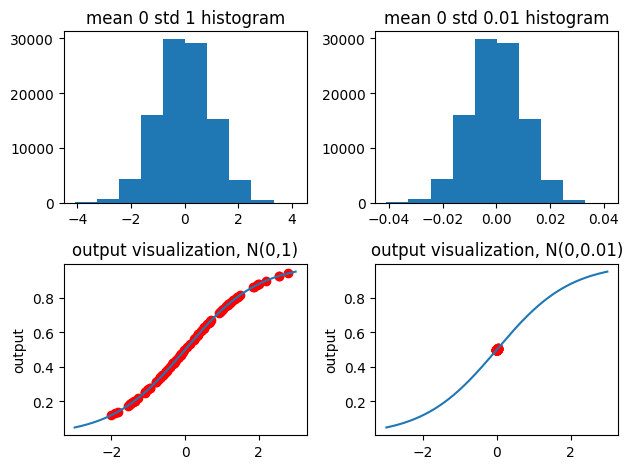

In [6]:
import matplotlib.pyplot as plt
temp = np.linspace(-3, 3,100000)
x = np.random.randn(100000)
x2 = 0.01*x
y = sigmoid(x)
y2 = sigmoid(x2)

plt.subplot(221)
plt.title('mean 0 std 1 histogram')
plt.hist(x)
plt.subplot(222)
plt.title('mean 0 std 0.01 histogram')
plt.hist(x2)

plt.subplot(223)
plt.title('output visualization, N(0,1)')
plt.plot(temp,sigmoid(temp))
plt.scatter(x[:100], y[:100],color='r')
plt.ylabel('output')

plt.subplot(224)
plt.title('output visualization, N(0,0.01)')
plt.plot(temp,sigmoid(temp))
plt.scatter(x2[:100], y2[:100],color='r')
plt.ylabel('output')
plt.tight_layout()

시각화 결과 sigmoid 함수의 중간에 출력값이 몰려있는것을 알 수 있다. 즉 출력값이 양 극단에 위치해서 발생하는 문제를 방지할 수 있다.

## 4.5.2 미니배치 학습 구현하기

In [7]:
from tensorflow import keras
from keras.utils import to_categorical
import time

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784) # flatten
x_test = x_test.reshape(10000, 784)
y_train = to_categorical(y_train) # one-hot
y_test = to_categorical(y_test)
(x_train, y_train), (x_test, y_test) = (x_train, y_train), (x_test, y_test)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

#하이퍼파라미터
iters_num = 1000 #반복 횟수
train_size = x_train.shape[0]
batch_size = 100,
learning_rate = 0.1

train_loss_list = []

start = time.time()
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, y_batch)
    
    #매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    if i % 100 == 0:
        print(f"{i}번째 반복:", loss)
print("학습시 걸린 시간 :", time.time() - start) 

0번째 반복: 2.245144008249538
100번째 반복: 0.9044653441317059


C:\Users\이정진\AppData\Local\Temp\ipykernel_29880\380896780.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


200번째 반복: 0.6462649565167915
300번째 반복: 0.5745608792541378
400번째 반복: 0.5951191533906619
500번째 반복: 0.3939874554438142
600번째 반복: 0.5483755801307375
700번째 반복: 0.4869423146243846
800번째 반복: 0.4878700097354372
900번째 반복: 0.40879824309183027
학습시 걸린 시간 : 5.134291410446167


train loss

Text(0.5, 0, 'num_iter')

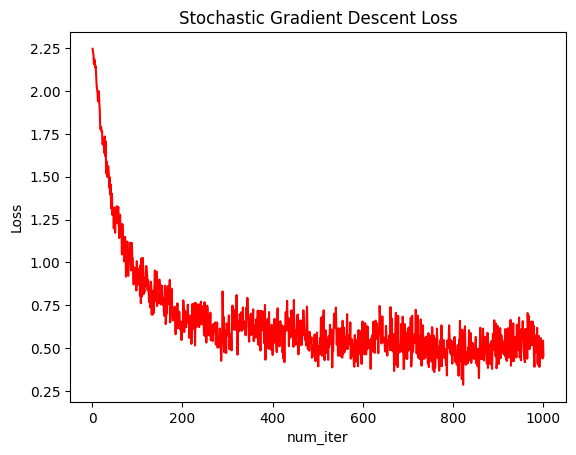

In [9]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,1001)), train_loss_list, color='r')
plt.title('Stochastic Gradient Descent Loss')
plt.ylabel('Loss')
plt.xlabel('num_iter')

하지만 train 데이터만 학습한 결과로는 이 학습이 범용적으로 잘 들어맞는지 알 수 없습니다. 따라서 test 데이터와 비교해주는 작업이 필요합니다.

## 4.5.3 시험 데이터로 평가하기

In [23]:
import numpy as np

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

#하이퍼파라미터
iters_num = 10000 #반복 횟수
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max((train_size / batch_size), 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size) # 복원추출?
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, y_batch)
    
    #매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, y_train)
        test_acc = network.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc |" + str(train_acc)+ ", " + str(test_acc))

train acc, test acc |0.1694, 0.169


C:\Users\이정진\AppData\Local\Temp\ipykernel_22468\380896780.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


train acc, test acc |0.8589666666666667, 0.8613
train acc, test acc |0.8627666666666667, 0.8618
train acc, test acc |0.8654, 0.8712
train acc, test acc |0.8512166666666666, 0.8546
train acc, test acc |0.875, 0.8793
train acc, test acc |0.8886833333333334, 0.8908
train acc, test acc |0.86725, 0.873
train acc, test acc |0.8778166666666667, 0.8858
train acc, test acc |0.8734333333333333, 0.8721
train acc, test acc |0.88005, 0.8826
train acc, test acc |0.8811, 0.8826
train acc, test acc |0.8763, 0.8837
train acc, test acc |0.8774166666666666, 0.8807
train acc, test acc |0.88325, 0.8873
train acc, test acc |0.8759666666666667, 0.8815
train acc, test acc |0.87285, 0.8774


Text(0.5, 0, 'num_iter')

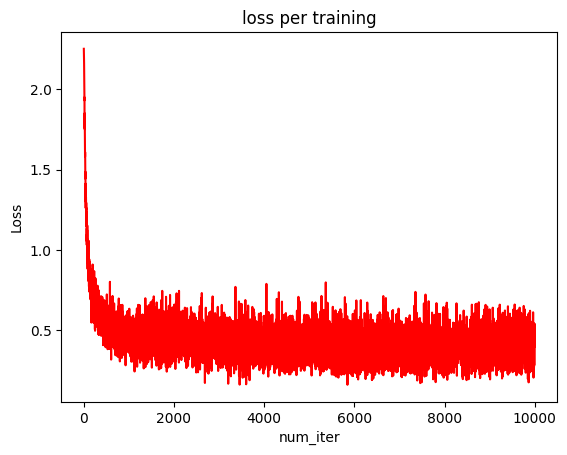

In [24]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,10001)), train_loss_list, color='r')
plt.title('loss per training')
plt.ylabel('Loss')
plt.xlabel('num_iter')

Text(0.5, 0, 'Epoch')

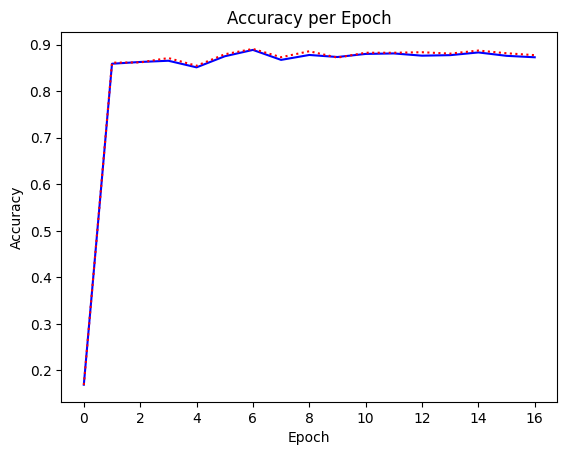

In [31]:
plt.plot(list(range(len(train_acc_list))), train_acc_list, color='b')
plt.plot(list(range(len(test_acc_list))), test_acc_list, color='r', linestyle='dotted')
plt.title('Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

train 데이터와 test 데이터의 accuracy가 거의 동일한 걸로 봐서 overfitting을 피해 잘 학습되었다.

## GD VS SGD 시간 비교

In [8]:
from tensorflow import keras
from keras.utils import to_categorical
import time

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.reshape(60000, 784) # flatten
x_test = x_test.reshape(10000, 784)
y_train = to_categorical(y_train) # one-hot
y_test = to_categorical(y_test)
(x_train, y_train), (x_test, y_test) = (x_train, y_train), (x_test, y_test)

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

#하이퍼파라미터
iters_num = 10000 #반복 횟수
train_size = x_train.shape[0]
batch_size = train_size
learning_rate = 0.1

train_loss_list = []

start = time.time()
for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    y_batch = y_train[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, y_batch)
    
    #매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    if i % 1000 == 0:
        print(f"{i}번째 반복:", loss)
print("학습시 걸린 시간 :", time.time() - start) #1000번 반복에 20분 걸림....

0번째 반복: 2.2823406771515162
1000번째 반복: 0.1715133836540868


KeyboardInterrupt: 

Text(0.5, 0, 'num_iter')

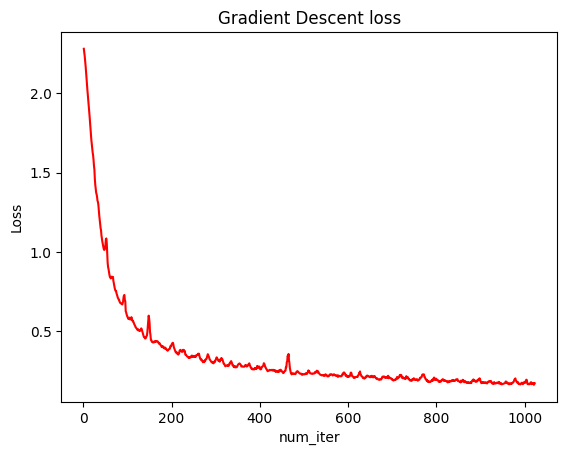

In [11]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,1024)), train_loss_list, color='r')
plt.title('Gradient Descent loss')
plt.ylabel('Loss')
plt.xlabel('num_iter')

### overfitting된 경우 시각화

In [52]:
l = np.argmax(y_train, axis=1)
over_x,over_y = x_train[np.where(l==5)] ,y_train[np.where(l==5)] #  label이 5인 데이터
over_x = np.concatenate([x_train, over_x,over_x,over_x,over_x,over_x,over_x,over_x]) # label이 5인 데이터 oversampling
over_y = np.concatenate([y_train, over_y,over_y,over_y,over_y,over_y,over_y,over_y])

In [64]:
import numpy as np

network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

#하이퍼파라미터
iters_num = 10000 #반복 횟수
train_size = over_x.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(int(train_size / batch_size), 1)

for i in range(iters_num):
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size) # 복원추출?
    x_batch = over_x[batch_mask]
    y_batch = over_y[batch_mask]
    
    # 기울기 계산
    grad = network.gradient(x_batch, y_batch)
    
    #매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2'):
        network.params[key] -= learning_rate * grad[key]
    
    # 학습 경과 기록
    loss = network.loss(x_batch, y_batch)
    train_loss_list.append(loss)
    
    # 1에폭당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(over_x, over_y)
        test_acc = network.accuracy(x_test, y_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc |" + str(train_acc)+ ", " + str(test_acc))

train acc, test acc |0.44277006952739745, 0.0892


C:\Users\이정진\AppData\Local\Temp\ipykernel_13844\380896780.py:3: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-x))


train acc, test acc |0.8439564254137442, 0.7778
train acc, test acc |0.8653659632250095, 0.8265
train acc, test acc |0.8833144455675008, 0.8262
train acc, test acc |0.8947900395111642, 0.859
train acc, test acc |0.8926664420553974, 0.8633
train acc, test acc |0.9009260110059522, 0.8676
train acc, test acc |0.8904407485681032, 0.8503
train acc, test acc |0.8891543385708598, 0.8504
train acc, test acc |0.8919211410252483, 0.8658
train acc, test acc |0.8877147845263255, 0.8462


Text(0.5, 0, 'num_iter')

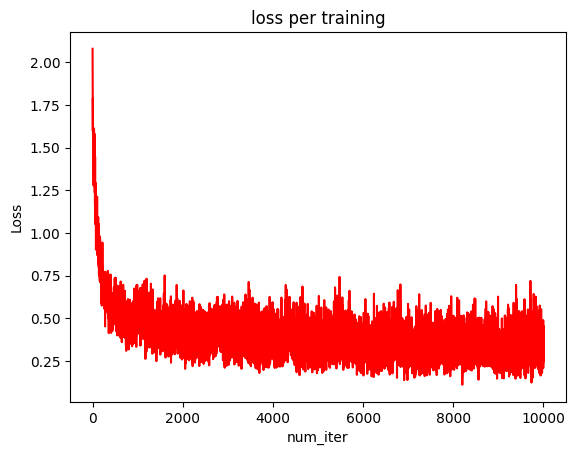

In [65]:
import matplotlib.pyplot as plt
plt.plot(list(range(1,10001)), train_loss_list, color='r')
plt.title('loss per training')
plt.ylabel('Loss')
plt.xlabel('num_iter')

Text(0.5, 0, 'Epoch')

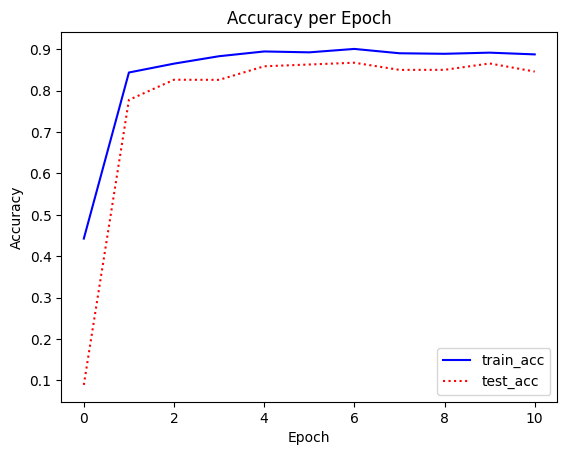

In [66]:
plt.plot(list(range(len(train_acc_list))), train_acc_list, color='b', label='train_acc')
plt.plot(list(range(len(test_acc_list))), test_acc_list, color='r', linestyle='dotted',label='test_acc')
plt.legend()
plt.title('Accuracy per Epoch')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

train 데이터의 accuracy에 비해 test accuracy가 낮은 것을 알 수 있다 -> overfitting

#### array image 시각화

In [38]:
# from PIL import Image as I
# I.fromarray(x_train[0])
# I.fromarray(x_train[0].reshape(28,28))

부족한점: 배치 나누는 법을 복원, 비복원 두 방법이 있는데 여기선 복원추출을 했다. 비복원추출로 배치처리를 구현하는법 공부가 필요할 것 같다.